In [2]:
import numpy as np
import scipy.stats, sys
import itertools

import matplotlib.pyplot as plt
sys.path.append('/home/jp/projects/python_tools') # This is just a plotting tool
import jp_mpl as jplot
%matplotlib inline   


### Assume you are analyzing a zenith distribution
#### Define a number of bins, sample size and shape of the distribution. All these should be irrelevant. It is just to make it more comprehensible

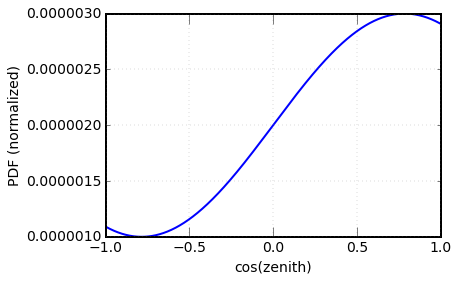

In [3]:
# cos(zenith) edges
xedges = [-1,1]
# Number of bins
xbins  = 24
# The z-axis of all histograms
zaxis  = np.linspace(xedges[0],xedges[1], xbins+1)

# The size of our experiment
events_to_draw = 5000

# Our infinite MC - it just has to be huge in comparison to the events "observed"
zenith = np.linspace(xedges[0],xedges[1], events_to_draw*100)

# This is the shape of the distribution. I just wanted to avoid it being flat and having zero bins
# You can modify it at will. Just make it positive
true_pdf  = 2.+np.sin(zenith*2)
true_pdf *= 1/np.sum(true_pdf)
plt.plot(zenith, true_pdf)
plt.xlabel('cos(zenith)')
plt.ylabel('PDF (normalized)')

plt.show()

### Get some events from your infinite MC - that's your data

Chi2  24.6359683972


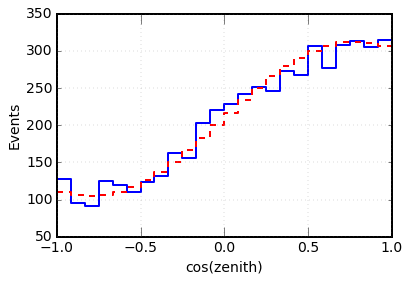

In [4]:
# Draw some events from that true pdf without replacement
data = np.random.choice(zenith, 
                        events_to_draw, 
                        replace=False,
                        p = true_pdf)

# Compare the true values between your events and the infinite MC
dbins, x = np.histogram(data, zaxis)
jplot.unfilledBar(zaxis, dbins)

perfect_data = true_pdf*events_to_draw
perfbins, x = np.histogram(zenith, zaxis, weights=perfect_data)
jplot.unfilledBar(zaxis, perfbins, linestyle='--', color='red')
plt.xlabel('cos(zenith)')
plt.ylabel('Events')


chi2 = np.sum((perfbins-dbins)**2/perfbins)
print 'Chi2 ', chi2

### Define your reconstruction parameters - including the unstable behavior

In [20]:
# Let's reconstruct that data N times
nrecos = 10

# These parameters are the usual ones for a reconstruction
fit_bias      = 0.
fit_sigma     = 0.05

# This parameter is the stability. Changes for every event, every time it is reconstructed
fit_stability = 0.1

### Reconstruct your infinite MC - with and without unstable behavior. Bin it.

In [21]:
# Let's get the reconstructed PDF using only the perfect reco
reco_pdf = zenith+np.random.normal(fit_bias, fit_sigma, zenith.shape)
reco_hist, x = np.histogram(reco_pdf, zaxis, weights=perfect_data)

# Now let's reconstruct the PDF using perfect reco + unstable behavior
unstable_pdf = reco_pdf+np.random.normal(0., fit_stability, zenith.shape)
unstable_hist, x = np.histogram(unstable_pdf, zaxis, weights=perfect_data)

### Reconstruct the "data" - with and without unstable behavior 

In [22]:
# First the normal reco - well defined
reco_resolution = np.random.normal(fit_bias, fit_sigma, data.shape)

# Then the reco stability - changes every time
reco_stability = np.random.normal(0., fit_stability, (nrecos,len(data)))

# Reconstruction (stable behavior)
perfect_reco = data+reco_resolution

# Reconstruction (with unstable behavior)
myreco = reco_stability+data+reco_resolution

### Verification - resolution with/without instability

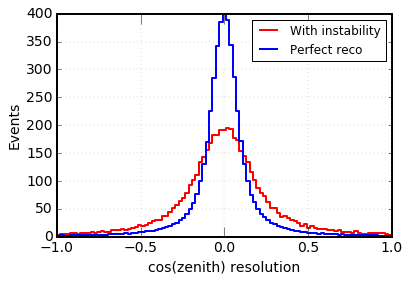

In [23]:
# Verifying resolutions
raxis = np.linspace(-1, 1, 100)
resolution = (reco_pdf - zenith)/zenith
r, newx = np.histogram(resolution, raxis , weights=perfect_data)

resolution_unstable = ((myreco - data)/data).flatten()
r2, newx = np.histogram(resolution_unstable, raxis)

jplot.unfilledBar(newx,r2*np.sum(r)/np.sum(r2), color = 'red', label='With instability')
jplot.unfilledBar(newx,r, label='Perfect reco')
plt.legend(loc=0)
plt.ylabel('Events')
plt.xlabel('cos(zenith) resolution')

### Verify one of the 10 reconstructions

Chi2 vs stable  37.7393161824
Chi2 vs unstable  17.3860061316


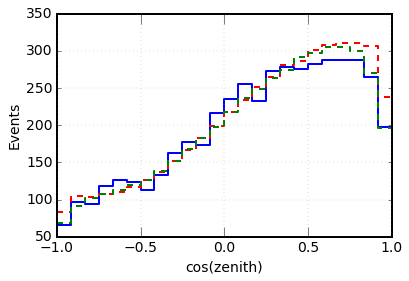

In [24]:
# Compare the i-th reconstruction
i = 4

one_reco, x = np.histogram(myreco[i,:], zaxis)
jplot.unfilledBar(x, one_reco)
jplot.unfilledBar(zaxis, reco_hist, linestyle='--', color='red')
jplot.unfilledBar(zaxis, unstable_hist, linestyle='--', color='green')
chi2 = np.sum((one_reco - reco_hist)**2/reco_hist)
chi2u= np.sum((one_reco - unstable_hist)**2/unstable_hist)
plt.xlabel('cos(zenith)')
plt.ylabel('Events')
print 'Chi2 vs stable ', chi2
print 'Chi2 vs unstable ', chi2u

### Start making all possible combinations - Compare vs the unstable reco in infinite MC

Done with 1
Done with 2
Done with 3
Done with 4
Done with 5
Done with 6
Done with 7
Done with 8
Done with 9
Done with 10


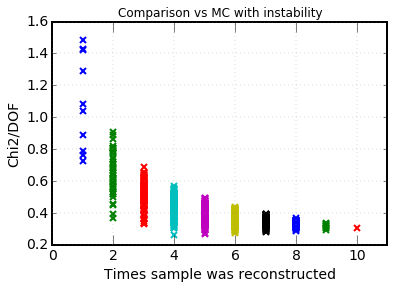

In [25]:
# Now let's start making combinatorics
all_chi2 = []
for ncombinations in range(1, nrecos+1):
    get_comb = itertools.combinations(range(0,nrecos),ncombinations)
    all_chi2.append([])
    while True:
        try:
            comb_indices  = get_comb.next()
            averaged_hist = np.zeros_like(reco_hist)
            for one_i in comb_indices:
                n, x = np.histogram(myreco[one_i,:], zaxis)
                averaged_hist += n/(1.*len(comb_indices))
            all_chi2[ncombinations-1].append(np.sum((averaged_hist - unstable_hist)**2/unstable_hist))          
        except:
            print 'Done with', ncombinations
            break
fig = plt.figure()
for i in range(1,nrecos+1):
    chi2_values = all_chi2[i-1][:]
    plt.plot([i]*len(chi2_values), np.array(chi2_values)/xbins, 'x')
    
plt.title('Comparison vs MC with instability')
plt.xlim([0, 11])
plt.xlabel('Times sample was reconstructed')
plt.ylabel('Chi2/DOF')

### Start making all possible combinations - Compare vs the stable reco in infinite MC

Done with 1
Done with 2
Done with 3
Done with 4
Done with 5
Done with 6
Done with 7
Done with 8
Done with 9
Done with 10


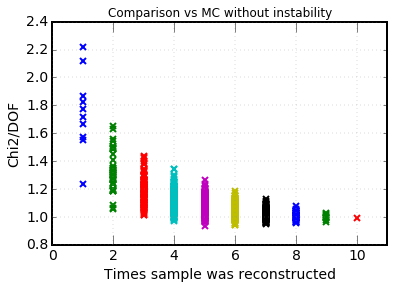

In [26]:
# Now let's start making combinatorics
all_chi2 = []
for ncombinations in range(1, nrecos+1):
    get_comb = itertools.combinations(range(0,nrecos),ncombinations)
    all_chi2.append([])
    while True:
        try:
            comb_indices  = get_comb.next()
            averaged_hist = np.zeros_like(reco_hist)
            for one_i in comb_indices:
                n, x = np.histogram(myreco[one_i,:], zaxis)
                averaged_hist += n/(1.*len(comb_indices))
            all_chi2[ncombinations-1].append(np.sum((averaged_hist - reco_hist)**2/reco_hist))          
        except:
            print 'Done with', ncombinations
            break
fig = plt.figure()
for i in range(1,nrecos+1):
    chi2_values = all_chi2[i-1][:]
    plt.plot([i]*len(chi2_values), np.array(chi2_values)/xbins, 'x')
    
plt.xlim([0, 11])
plt.title('Comparison vs MC without instability')

plt.xlabel('Times sample was reconstructed')
plt.ylabel('Chi2/DOF')